In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib as mpl
# 日本語フォントの指定
mpl.rcParams['font.family'] = 'IPAexGothic' # ここにインストールしたフォント名を入れる

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from nyaggle.feature.category_encoder import TargetEncoder

from nyaggle.experiment import run_experiment

In [2]:
train = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/train_feature_ver2.csv')
test = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/test_feature_ver2.csv')
era = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/era.csv')
sample_submission = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/sample_submission.csv')

In [3]:
test.head()

,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,緯度,...,502,503,504,505,506,507,508,509,510,511
0,NaN,工芸品,日本,江戸,京都府（京都府）,NaN,NaN,相国寺,NaN,NaN,...,-0.025584,-0.012252,-0.012271,0.072874,-0.039801,-0.021271,0.012467,0.034596,-0.023817,-0.030492
1,NaN,絵画,日本,平安,和歌山県（和歌山県）,NaN,NaN,西禅院,財団法人高野山文化財保存会,NaN,...,-0.026519,-0.036004,-0.035254,0.027655,0.045121,-0.018657,0.041083,0.062436,-0.019814,-0.036495
2,NaN,絵画,日本,平安,東京都（東京都）,東京都世田谷区上野毛3-9-25,公益財団法人五島美術館,東急株式会社,NaN,35.612290,...,0.032094,-0.013380,-0.010027,0.061131,-0.004584,-0.046228,0.044919,0.028419,-0.051641,-0.015564
3,NaN,近世以前／神社,NaN,江戸前期,和歌山県,和歌山県有田郡広川町大字上中野,NaN,廣八幡宮,NaN,34.017835,...,-0.025453,-0.023700,0.009060,0.075206,0.018822,-0.062776,0.016009,-0.022042,-0.035110,-0.050560
4,NaN,彫刻,日本,平安,山形県（山形県）,NaN,NaN,吉祥院,NaN,NaN,...,-0.037568,-0.031847,-0.014172,0.075822,0.017364,-0.073429,-0.018416,0.025913,0.005010,-0.012969


In [4]:
#categorical変数抽出
cat_cols = [c for c in test.columns if train[c].dtype == np.object]
cat_cols.remove('string') # これは取り除かないといけない

# numerical変数抽出
num_cols = [c for c in test.columns if train[c].dtype != np.object]

#目的変数抽出
target_col = 'is_kokuhou'

print(cat_cols)
print(num_cols)
print(target_col)

['棟名', '種別2', '国', '時代', '都道府県 ※美工品は「所有者住所（所在都道府県）」', '所在地', '保管施設の名称', '所有者名', '管理団体又は責任者']
['緯度', '経度', '開始', '終了', '緯度*経度', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [5]:
print(len(cat_cols) + len(num_cols))

526


In [6]:
#カテゴリ変数の欠損値をmissingで埋める
train[cat_cols] = train[cat_cols].fillna('missing')
test[cat_cols] = test[cat_cols].fillna('missing')

0:	learn: 0.5087133	test: 0.5102196	best: 0.5102196 (0)	total: 262ms	remaining: 43m 36s
1:	learn: 0.3948707	test: 0.4060026	best: 0.4060026 (1)	total: 528ms	remaining: 43m 57s
2:	learn: 0.3268371	test: 0.3458469	best: 0.3458469 (2)	total: 816ms	remaining: 45m 18s
3:	learn: 0.2798241	test: 0.3065287	best: 0.3065287 (3)	total: 1.14s	remaining: 47m 28s
4:	learn: 0.2483695	test: 0.2815341	best: 0.2815341 (4)	total: 1.43s	remaining: 47m 47s
5:	learn: 0.2260308	test: 0.2684198	best: 0.2684198 (5)	total: 1.71s	remaining: 47m 25s
6:	learn: 0.2072252	test: 0.2557402	best: 0.2557402 (6)	total: 1.96s	remaining: 46m 41s
7:	learn: 0.1960621	test: 0.2501253	best: 0.2501253 (7)	total: 2.22s	remaining: 46m 8s
8:	learn: 0.1830547	test: 0.2430503	best: 0.2430503 (8)	total: 2.51s	remaining: 46m 30s
9:	learn: 0.1750354	test: 0.2405241	best: 0.2405241 (9)	total: 2.77s	remaining: 46m 7s
10:	learn: 0.1653675	test: 0.2376316	best: 0.2376316 (10)	total: 3.03s	remaining: 45m 48s
11:	learn: 0.1583371	test: 0.237

/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 32066 (\N{CJK UNIFIED IDEOGRAPH-7D42}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 20102 (\N{CJK UNIFIED IDEOGRAPH-4E86}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 31278 (\N{CJK UNIFIED IDEOGRAPH-7A2E}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 2

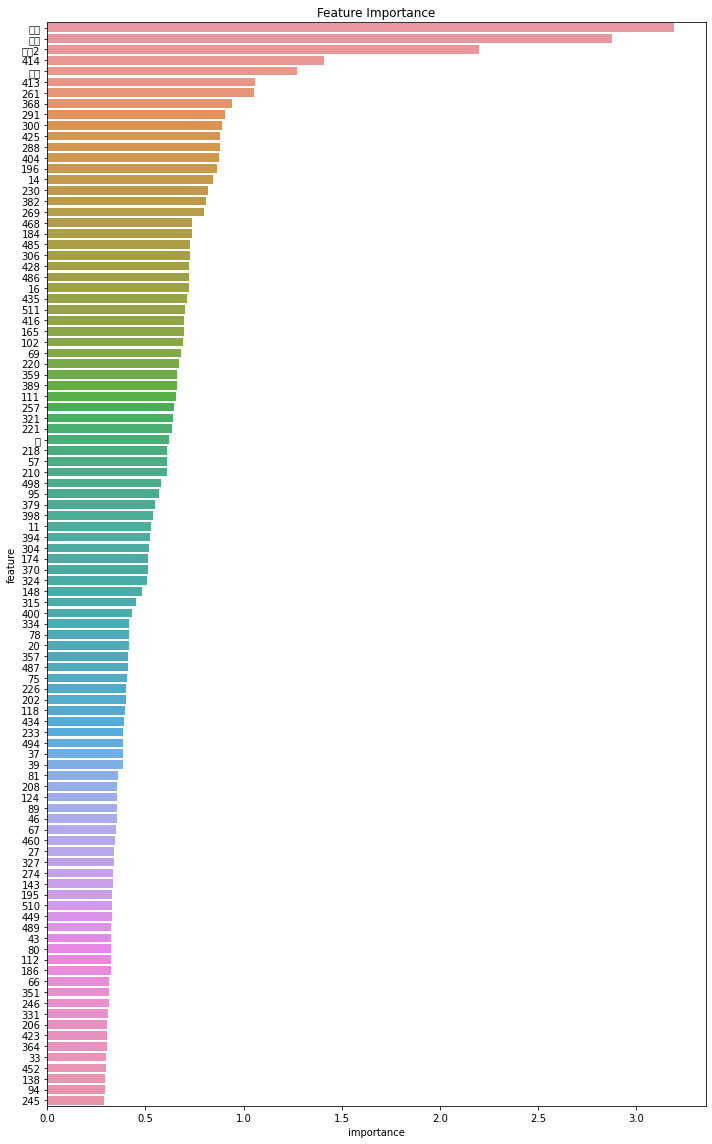

In [20]:
params = {
        "loss_function": 'Logloss', #'MAE', 'Logloss', 'AUC', 'MultiClass','RMSE'
        "learning_rate": 0.2, #0.05
        "iterations": 10000,
        "depth" : 10,
        "early_stopping_rounds":100,
        "random_seed":42531,
        #"cat_features": cat_cols,
    }

result = run_experiment(
    params,
    train[num_cols + cat_cols],
    train[target_col],
    test[num_cols + cat_cols],
    cv=StratifiedKFold(5, shuffle=True, random_state=42531), # cv=5,
    #groups = train.book_id,
    #categorical_feature=["user_id","book_id"],→これLGBM用？
    algorithm_type='cat'
)

In [9]:
print(result.metrics) # Evalulation metrics for each fold

[0.788047504025765, 0.774730273752013, 0.7797101449275363, 0.7611473429951691, 0.7660222911896347, 0.7725706583290176]


In [10]:
result.importance     # Feature importance for each fold

[                       feature  importance
 0                           緯度    0.418569
 1                           経度    0.000000
 2                           開始    1.333299
 3                           終了    2.624102
 4                        緯度*経度    0.402293
 ..                         ...         ...
 521  都道府県 ※美工品は「所有者住所（所在都道府県）」    0.000000
 522                        所在地    0.000000
 523                    保管施設の名称    0.000000
 524                       所有者名    0.000000
 525                  管理団体又は責任者    0.062900
 
 [526 rows x 2 columns],
                        feature  importance
 0                           緯度    0.000000
 1                           経度    0.000000
 2                           開始    0.623014
 3                           終了    4.381673
 4                        緯度*経度    0.000000
 ..                         ...         ...
 521  都道府県 ※美工品は「所有者住所（所在都道府県）」    0.420668
 522                        所在地    0.000000
 523                    保管施設の名称    0.000000
 524 

In [22]:
print(result.test_prediction)  # Test prediction in numpy array
print(result.oof_prediction)   # Out-of-fold prediction in numpy array

[0.01794321 0.14319904 0.31869019 ... 0.08071493 0.03927134 0.03159008]
[0.03048165 0.02652862 0.12343364 ... 0.00674353 0.1143109  0.02063747]


In [23]:
# データ全体のF1スコアを計算 & 閾値の最適化
from sklearn.metrics import f1_score

def find_optimal_threshold(y_true, y_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    for threshold in thresholds:
        y_pred = (y_scores > threshold).astype(int)
        score = f1_score(y_true, y_pred)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

# 例として使用するデータ（実際にはモデルからの予測値と実際のラベルを使用）
y_true = train[target_col].values
y_scores = result.oof_prediction

best_threshold, best_f1_score = find_optimal_threshold(y_true, y_scores)
print(f"Best threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

Best threshold: 0.11111111111111112
Best F1 Score: 0.31352057478772044


In [24]:
# 閾値を超える確率を持つ要素を1に、それ以外を0に変換
y_pred = (result.test_prediction > best_threshold).astype(int)
print(y_pred)
print(y_pred.shape)

[0 1 1 ... 0 0 0]
(10065,)


In [25]:
sample_submission['is_kokuhou'] = y_pred
sample_submission

,is_kokuhou
0,0
1,1
2,1
3,0
4,0
...,...
10060,0
10061,0
10062,0
10063,0


In [26]:
sample_submission["is_kokuhou"].value_counts()

0    8587
1    1478
Name: is_kokuhou, dtype: int64

In [27]:
sample_submission.to_csv('catboost_ver3.csv', index=False)

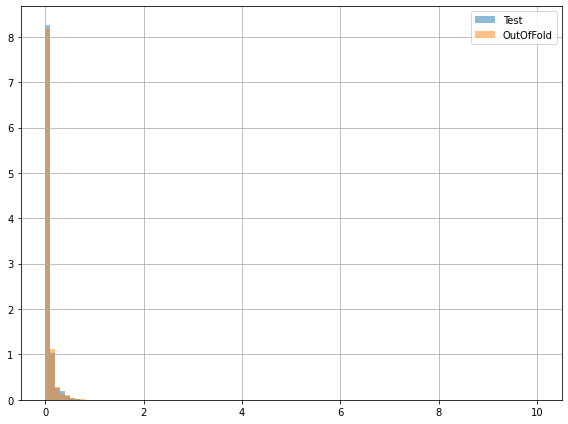

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 10, 100)
ax.hist(result.test_prediction, bins=bins, density=True, alpha=.5, label="Test")
ax.hist(result.oof_prediction, bins=bins, density=True, alpha=.5, label="OutOfFold")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()